# architecture-12 ( Basic Regression Model Copy From 05 )

What's new:

1- Add keras tuner

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import callbacks

In [3]:
df = pd.read_csv('datasets-12/XAGUSD-H1-rates.csv', sep='\t').dropna()

In [4]:
# === Scaling Features ===
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<TICKVOL>']])

In [5]:
# === Prepare sequences ===
def create_sequences(features, target, window, horizon):
    X, y = [], []
    for i in range(window, len(features) - horizon):
        X.append(features[i - window:i])
        y.append(target[i:i + horizon])
    return np.array(X), np.array(y)


WINDOW_SIZE = 60
FORECAST_HORIZON = 10


close_scaler = MinMaxScaler()
scaled_close = close_scaler.fit_transform(df[['<CLOSE>']])
X, y = create_sequences(scaled, scaled_close, WINDOW_SIZE, FORECAST_HORIZON)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [6]:
# === Define the HyperModel Function ===
from keras_tuner import HyperModel

class LSTMHyperModel(HyperModel):
    def __init__(self, input_shape, output_dim):
        self.input_shape = input_shape
        self.output_dim = output_dim

    def build(self, hp):
        model = Sequential()

        # Tune LSTM units
        units = hp.Int('lstm_units', min_value=16, max_value=128, step=16)
        model.add(LSTM(units, input_shape=self.input_shape))

        # Optional extra dense layer
        if hp.Boolean('use_dense'):
            model.add(Dense(hp.Int('dense_units', 16, 128, step=16), activation='relu'))

        # Output layer
        model.add(Dense(self.output_dim))

        # Tune optimizer learning rate
        lr = hp.Float('lr', min_value=1e-4, max_value=1e-2, sampling='log')
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

        model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
        return model

In [7]:
# === Instantiate the Tuner ===
from keras_tuner.tuners import RandomSearch

tuner = RandomSearch(
    LSTMHyperModel(input_shape=(X_train.shape[1], X_train.shape[2]), output_dim=FORECAST_HORIZON),
    objective='val_loss',
    max_trials=20,
    executions_per_trial=3,
    directory='tuner_dir',
    project_name='forex_lstm_tuning'
)


I0000 00:00:1752215147.768926    5686 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2449 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5
/home/saeed/repositories/machine-learning/forex-prediction/envs/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
# === Search the Best Hyperparameters ===
es_tuner = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

tuner.search(
    X_train, y_train,
    epochs=20,
    validation_split=0.2,
    callbacks=[es_tuner],
    verbose=1
)

Trial 20 Complete [00h 10m 32s]
val_loss: 0.00014033246649584422

Best val_loss So Far: 0.00013462495796071985
Total elapsed time: 02h 35m 35s


In [9]:
# === Retrieve and Train the Best Model ===
es_final = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
mc_final = callbacks.ModelCheckpoint(filepath='best_final_model.keras', monitor='val_loss', save_best_only=True)

best_model = tuner.get_best_models(num_models=1)[0]

# Optionally fine-tune more
history = best_model.fit(
    X_train, y_train,
    epochs=200,
    validation_split=0.2,
    callbacks=[es_final, mc_final],  # or define separately callbacks
    verbose=1
)


Epoch 1/200


/home/saeed/repositories/machine-learning/forex-prediction/envs/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/saeed/repositories/machine-learning/forex-prediction/envs/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1101/1101 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 8.4583e-05 - mae: 0.0057 - val_loss: 1.3864e-04 - val_mae: 0.0082
Epoch 2/200
1101/1101 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 8.0458e-05 - mae: 0.0055 - val_loss: 2.4641e-04 - val_mae: 0.0120
Epoch 3/200
1101/1101 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 7.4795e-05 - mae: 0.0054 - val_loss: 1.3951e-04 - val_mae: 0.0082
Epoch 4/200
1101/1101 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 7.9475e-05 - mae: 0.0054 - val_loss: 4.2302e-04 - val_mae: 0.0178
Epoch 5/200
1101/1101 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 7.8069e-05 - mae: 0.0055 - val_loss: 1.5734e-04 - val_mae: 0.0087
Epoch 6/200
1101/1101 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 7.5360e-05 - mae: 0.0054 - val_loss: 1.4130e-04 - val_mae: 0.0084
Epoch 7/200
1101/1101 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 8.1090e-05 - mae: 0.0055 - val_loss: 1.8422e-04 - val_mae: 0.0104
Epoch 8/200
1101/1101 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 7.7839e-05 - mae: 0.0054 - val_loss: 1.3538e-0

In [10]:
# === Load the last 60 rows from a separate CSV file for prediction ===
input_df = pd.read_csv('datasets-12/new-data-for-test/rows-60-from-20240503/rows-60-from-20240503.csv',
                       sep='\t').dropna()
input_scaled = scaler.transform(
    input_df[['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<TICKVOL>']])
input_sequence = np.expand_dims(input_scaled, axis=0)  # shape: (1, 60, 5)

# === Predict the next 10 candles + Inverse scale ===
pred = best_model.predict(input_sequence)
prediction = close_scaler.inverse_transform(pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


# plot section

In [11]:
import sys

sys.path.insert(1, '../utils')
import forex_plot_utils
import os

# PARAMETERS
csv1_path = 'datasets-12/new-data-for-test/rows-60-from-20240503/latest-4-for-history.csv'
csv3_path = 'datasets-12/new-data-for-test/rows-60-from-20240503/after.csv'
plot_title = 'Actual vs Predicted Forex Closing Prices'
output_plot_path = None  # e.g., 'output.png'

# LOAD DATA FROM CSVS
historical_df = forex_plot_utils.load_csv_with_datetime(csv1_path) if os.path.exists(csv1_path) else None
actual_future_df = forex_plot_utils.load_csv_with_datetime(csv3_path) if os.path.exists(csv3_path) else None

# LOAD DATA FROM PREDICTION

# Combine <DATE> and <TIME> columns into a datetime
input_df['DATETIME'] = pd.to_datetime(input_df['<DATE>'] + ' ' + input_df['<TIME>'])

last_timestamp = input_df['DATETIME'].iloc[-1]
datetime_index = pd.date_range(start=last_timestamp + pd.Timedelta(hours=1), periods=len(prediction[0]), freq='h')

# Create DataFrame
predicted_df = pd.DataFrame({'DATETIME': datetime_index, '<CLOSE>': prediction[0]})

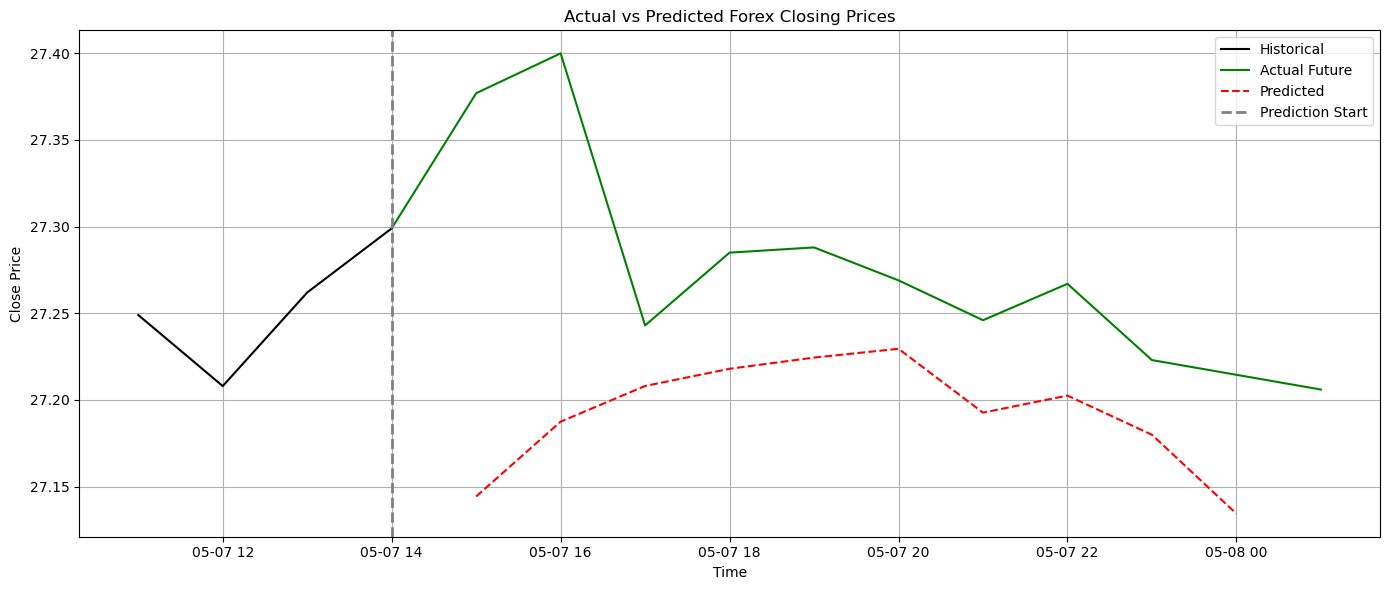

In [12]:
# PLOT
forex_plot_utils.plot_all_series(
    historical_df=historical_df,
    predicted_df=predicted_df,
    actual_future_df=actual_future_df,
    title=plot_title,
    output_path=output_plot_path
)

In [13]:
from datetime import datetime
import os
import pandas as pd
import matplotlib.pyplot as plt

# === Create timestamp and paths ===
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_filename = f'model_{timestamp}.keras'
model_path = os.path.join('saved_models', model_filename)

# Directory to hold logs and extras
log_dir = os.path.join('saved_models', f'model_{timestamp}_logs')
os.makedirs(log_dir, exist_ok=True)

# === Save model ===
best_model.save(model_path)

# === Save training history ===
history_df = pd.DataFrame(history.history)
history_df.to_csv(os.path.join(log_dir, 'training_history.csv'), index=False)

# === Save training loss plot ===
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(log_dir, 'training_loss.png'))
plt.close()

# === Save model summary and final performance ===
with open(os.path.join(log_dir, 'model_log.txt'), 'w') as f:
    best_model.summary(print_fn=lambda x: f.write(x + '\n'))
    final_train_loss = history.history['loss'][-1]
    final_test_loss, final_test_mae = best_model.evaluate(X_test, y_test, verbose=0)
    f.write(f'\nFinal Training Loss: {final_train_loss:.6f}\n')
    f.write(f'Final Test Loss: {final_test_loss:.6f}\n')
    f.write(f'Final Test MAE : {final_test_mae:.6f}\n')
